# Unit 3: Lesson 6: Project 5 Cancer Diagnosis Challenge:

Eva Rubin

January 2019

## Objectives:

- Create a model to predict breast cancer
- Determine traits that are most indicative of malignant diagnosis

Data source: http://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Original%29

In [3]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# sklearn: import cross validation and KFold
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from matplotlib.mlab import PCA as mlabPCA
from sklearn.preprocessing import StandardScaler

# To correct class imbalance problem
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.datasets import make_classification
from sklearn import preprocessing

# for kselectbest
import sklearn.feature_selection as fs

# SVM
from sklearn import svm
from sklearn.svm import SVR
from sklearn.svm import SVC

# Ensemble
from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import mean_squared_error

import itertools

# Create ROC curve and calculate AUC
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from scipy import interp


In [4]:
# Grab data, header = None because first row was being used as header
df = pd.read_csv((
    "http://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data"), header=None)

In [5]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [6]:
# Name columns
df.rename(columns={0: 'id', 1: 'dx', 2: 'mean_radius', 3: 'mean_texture',
       4: 'mean_perimeter', 5: 'mean_area', 6: 'mean_smoothness', 7: 'mean_compactness', 8: 'mean_concavity', 
       9: 'mean_concave_points', 10: 'mean_symmetry', 11: 'mean_fractal_dimension',
       12: 'se_radius', 13: 'se_texture', 14: 'se_perimeter', 15: 'se_area',
       16: 'se_smoothness', 17: 'se_compactness', 18: 'se_concavity', 
       19: 'se_concave_points', 20: 'se_symmetry', 21: 'se_fractal_dimension',
       22: 'worst_radius', 23: 'worst_texture', 24: 'worst_perimeter', 25: 'worst_area',
       26: 'worst_smoothness', 27: 'worst_compactness', 28: 'worst_concavity', 
       29: 'worst_concave_points', 30: 'worst_symmetry', 31: 'worst_fractal_dimension'}, inplace=True)

df.head()


,id,dx,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_points,...,worst_radius,worst_texture,worst_perimeter,worst_area,worst_smoothness,worst_compactness,worst_concavity,worst_concave_points,worst_symmetry,worst_fractal_dimension
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [7]:
df.describe()

,id,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_points,mean_symmetry,...,worst_radius,worst_texture,worst_perimeter,worst_area,worst_smoothness,worst_compactness,worst_concavity,worst_concave_points,worst_symmetry,worst_fractal_dimension
count,5.690000e+02,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,3.037183e+07,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,1.250206e+08,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,8.670000e+03,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,8.692180e+05,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,9.060240e+05,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,8.813129e+06,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,9.113205e+08,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [8]:
# Get age stats by partner categories
df.groupby('dx').mean_radius.describe()

,count,mean,std,min,25%,50%,75%,max
dx,,,,,,,,
B,357.0,12.146524,1.780512,6.981,11.080,12.200,13.37,17.85
M,212.0,17.462830,3.203971,10.950,15.075,17.325,19.59,28.11


In [13]:
# https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8
# take out string related columns to avoid errors and remove all other added columns as well

columns = ['mean_radius', 'mean_texture', 'mean_perimeter',
       'mean_area', 'mean_smoothness', 'mean_compactness', 'mean_concavity',
       'mean_concave_points', 'mean_symmetry', 'mean_fractal_dimension',
       'se_radius', 'se_texture', 'se_perimeter', 'se_area', 'se_smoothness',
       'se_compactness', 'se_concavity', 'se_concave_points', 'se_symmetry',
       'se_fractal_dimension', 'worst_radius', 'worst_texture',
       'worst_perimeter', 'worst_area', 'worst_smoothness',
       'worst_compactness', 'worst_concavity', 'worst_concave_points',
       'worst_symmetry', 'worst_fractal_dimension']

X = df[columns]

y = df['dx']

# Will stratify data to deal with class imbalance and make sure training and test sets share same ratio of M to B:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=0, stratify=y)
logreg = LogisticRegression(solver='liblinear')
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [17]:
y_pred_logreg = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))


Accuracy of logistic regression classifier on test set: 0.95


## Confusion Matrix for Logistic Regression

In [18]:
# Define function for pretty confusion matrix
# https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels

def plot_confusion_matrix(cm,
                          target_names,
                          title='Cancer Diagnosis Prediction Confusion matrix',
                          cmap=None,
                          normalize=False):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    print(classification_report(y_test, y_pred))


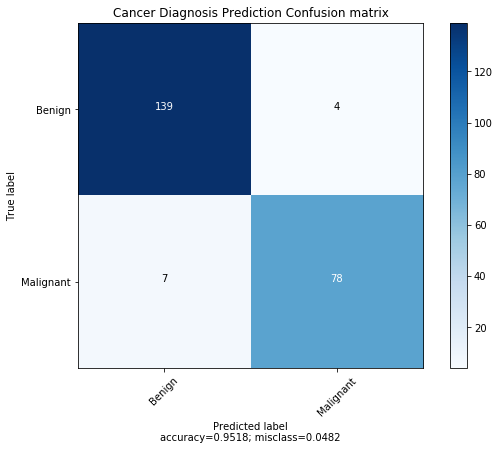

              precision    recall  f1-score   support

           B       0.95      0.97      0.96       143
           M       0.95      0.92      0.93        85

   micro avg       0.95      0.95      0.95       228
   macro avg       0.95      0.94      0.95       228
weighted avg       0.95      0.95      0.95       228



In [21]:
y_pred = y_pred_logreg
cm = confusion_matrix(y_test, y_pred_logreg)
target_names = 'Benign', 'Malignant'

plot_confusion_matrix(cm, target_names)

In [22]:
# Simpler way to visualize confusion matrix:

pd.DataFrame(
    confusion_matrix(y_test, y_pred_logreg),
    columns=['Predicted Benign', 'Predicted Malignant'],
    index=['True Benign', 'True Malignant']
)

,Predicted Benign,Predicted Malignant
True Benign,139,4
True Malignant,7,78


In [23]:
 print(classification_report(y_test, y_pred_logreg))

              precision    recall  f1-score   support

           B       0.95      0.97      0.96       143
           M       0.95      0.92      0.93        85

   micro avg       0.95      0.95      0.95       228
   macro avg       0.95      0.94      0.95       228
weighted avg       0.95      0.95      0.95       228



## Use kselectbest to identify top 20 important features as measured by F-Scores

In [24]:
# trying k selectbest
# https://stackoverflow.com/questions/49214001/what-do-these-f-scores-mean-using-selectkbest-feature
y_selectbest = df['dx']
X_selectbest = df.drop(['id','dx'], axis=1).dropna()

selector = fs.SelectKBest(k=15)

selector.fit(X_selectbest, y_selectbest)
names = X_selectbest.columns.values[selector.get_support()]

scores = selector.scores_[selector.get_support()]

names_scores = list(zip(names, scores))

ns_df = pd.DataFrame(data = names_scores, columns=
                     ['Feature_names','F_Scores'])

ns_df_sorted = ns_df.sort_values(['F_Scores','Feature_names'], ascending =
  [False, True])

print(ns_df_sorted)

           Feature_names    F_Scores
14  worst_concave_points  964.385393
10       worst_perimeter  897.944219
5    mean_concave_points  861.676020
9           worst_radius  860.781707
1         mean_perimeter  697.235272
11            worst_area  661.600206
0            mean_radius  646.981021
2              mean_area  573.060747
4         mean_concavity  533.793126
13       worst_concavity  436.691939
3       mean_compactness  313.233079
12     worst_compactness  304.341063
6              se_radius  268.840327
7           se_perimeter  253.897392
8                se_area  243.651586


In [25]:
# Isolate top 20 features
df_top_20 = df[['dx','worst_concave_points', 'worst_perimeter', 'mean_concave_points', 'worst_radius',
                  'mean_perimeter', 'worst_area', 'mean_radius', 'mean_area', 'mean_concavity', 'worst_concavity', 
                  'mean_compactness', 'worst_compactness', 'se_radius', 'se_perimeter', 'se_area', 'worst_texture',
                  'worst_smoothness', 'worst_symmetry', 'mean_texture', 'se_concave_points'
                 ]]


In [29]:
# https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8
# take out string related columns to avoid errors and remove all other added columns as well

columns_top = ['worst_concave_points', 'worst_perimeter', 'mean_concave_points', 'worst_radius',
                  'mean_perimeter', 'worst_area', 'mean_radius', 'mean_area', 'mean_concavity', 'worst_concavity', 
                  'mean_compactness', 'worst_compactness', 'se_radius', 'se_perimeter', 'se_area', 'worst_texture',
                  'worst_smoothness']

X2 = df[columns_top]

y2 = df['dx']

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=.4, random_state=0, stratify=y2)
logreg2 = LogisticRegression(solver='liblinear')
logreg2.fit(X_train2, y_train2)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [30]:
y_pred = logreg2.predict(X_test2)

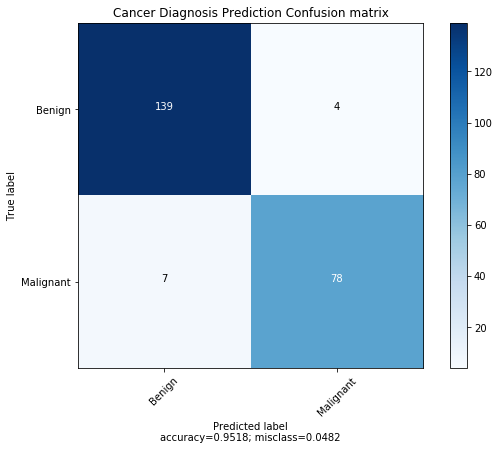

              precision    recall  f1-score   support

           B       0.95      0.97      0.96       143
           M       0.95      0.92      0.93        85

   micro avg       0.95      0.95      0.95       228
   macro avg       0.95      0.94      0.95       228
weighted avg       0.95      0.95      0.95       228



In [31]:
cm = confusion_matrix(y_test, y_pred)
target_names = 'Benign', 'Malignant'

plot_confusion_matrix(cm, target_names)

## Problem with this logistic regression for this data: will move on to use Gradient Boosting Model

There is an imbalance in samples.

- https://stackoverflow.com/questions/26221312/dealing-with-the-class-imbalance-in-binary-classification/26244744#26244744

Standard classifier algorithms like Decision Tree and Logistic Regression have a bias towards classes which have number of instances. They tend to only predict the majority class data. The features of the minority class are treated as noise and are often ignored. Thus, there is a high probability of misclassification of the minority class as compared to the majority class.


Evaluation of a classification algorithm performance is measured by the Confusion Matrix which contains information about the actual and the predicted class.

However, while working in an imbalanced domain accuracy is not an appropriate measure to evaluate model performance. For eg: A classifier which achieves an accuracy of 98 % with an event rate of 2 % is not accurate, if it classifies all instances as the majority class. And eliminates the 2 % minority class observations as noise.

## Use Gradient Boosting Model to classify

understanding AUC - Area Under the Curve:
- https://towardsdatascience.com/understanding-gradient-boosting-machines-9be756fe76ab

Understanding ROC - Receiver Operating Characteristic:
- https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

In Depth: Parameter tuning for Gradient Boosting:
- https://medium.com/all-things-ai/in-depth-parameter-tuning-for-gradient-boosting-3363992e9bae

Fine Tuning a classifier:
- https://www.kaggle.com/kevinarvai/fine-tuning-a-classifier-in-scikit-learn

Random:
- https://medium.com/cracking-the-data-science-interview/the-10-statistical-techniques-data-scientists-need-to-master-1ef6dbd531f7

Practical Tips for Class Imbalance in Binary Classification:
- https://medium.com/coinmonks/practical-tips-for-class-imbalance-in-binary-classification-6ee29bcdb8a7

Metrics for Classifiers:
- https://www.nature.com/articles/nmeth.3945

In [32]:
def modelfit(alg, df, predictors, performCV=True, printFeatureImportance=True, cv_folds=5):
    
    #Fit the algorithm on the data
    alg.fit(X_train, y_train)
        
    #Predict training set:
    df_predictions = alg.predict(X_train)
    df_predprob = alg.predict_proba(X_train)[:,1]
  
    #Perform cross-validation:
    if performCV:
        cv_score = cross_val_score(alg, X_train, y_train, cv=cv_folds, scoring='roc_auc')
    
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(y_train.values, df_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(y_train, df_predprob))
    
    if performCV:
        print("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')
    
    # get roc/auc info
    # https://stackoverflow.com/questions/35953300/valueerror-data-is-not-binary-and-pos-label-is-not-specified-for-roc-curve/35953684
    Y_score = alg.predict_proba(X_test)[:,1]
    fpr = dict()
    tpr = dict()
    fpr, tpr, _ = roc_curve(y_test, Y_score, pos_label='M')

    roc_auc = dict()
    roc_auc = auc(fpr, tpr)

    # make the plot
    
    plt.figure(figsize=(5,5))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.title("Test Data")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)
    plt.plot(fpr, tpr, label='AUC = {0}'.format(roc_auc))        
    plt.legend(loc="lower right", shadow=True, fancybox =True) 
    plt.show()

    # Confusion Matrix to identify Type I and Type II Errors:
    y_pred_confusion_matrix = alg.predict(X_test)

    cm = confusion_matrix(y_test, y_pred_confusion_matrix)
    target_names = 'Benign', 'Malignant'

    plot_confusion_matrix(cm, target_names, title='Test Data: Cancer Diagnosis Confusion Matrix')
    
    # See if stratifying the test data makes a difference in scores
    # https://medium.com/coinmonks/practical-tips-for-class-imbalance-in-binary-classification-6ee29bcdb8a7
    metric_names = ['f1', 'roc_auc', 'average_precision', 'accuracy', 'precision', 'recall']
    
#     scores_df = pd.DataFrame(index=metric_names, columns=['Random-CV', 'Stratified-CV']) # to store the scores
#     cv = KFold(n_splits=5)
#     scv = StratifiedKFold(n_splits=5)
#     lb = preprocessing.LabelBinarizer()
#     lb.fit(y_train)

#     for metric in metric_names:
#         score1 = cross_val_score(alg, X_test, y_test, scoring=metric, cv=cv).mean()
#         score2 = cross_val_score(alg, X_test, y_test, scoring=metric, cv=scv).mean()
#         scores_df.loc[metric] = [score1, score2]

### Baseline GBM Model


Model Report
Accuracy : 1
AUC Score (Train): 1.000000
CV Score : Mean - 0.9824472 | Std - 0.01202887 | Min - 0.9683721 | Max - 1


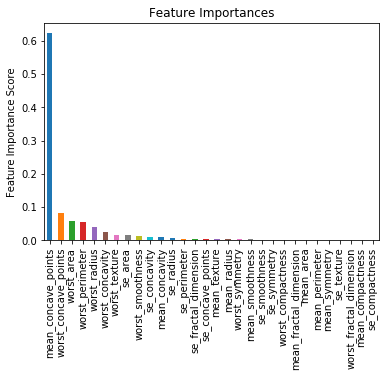

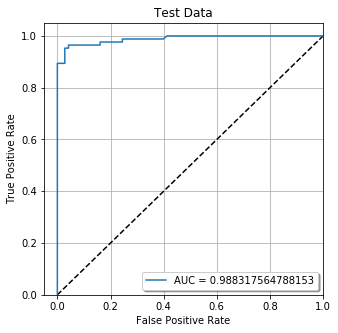

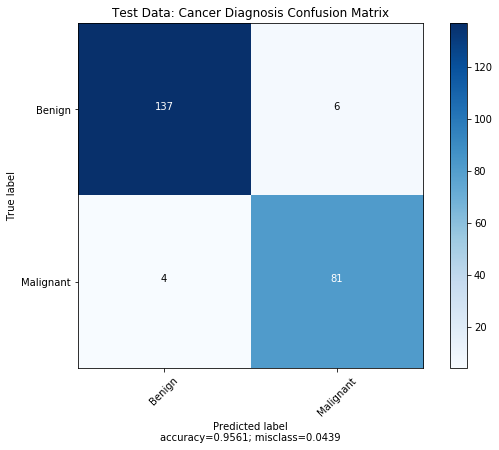

              precision    recall  f1-score   support

           B       0.95      0.97      0.96       143
           M       0.95      0.92      0.93        85

   micro avg       0.95      0.95      0.95       228
   macro avg       0.95      0.94      0.95       228
weighted avg       0.95      0.95      0.95       228



In [33]:
#Choose all predictors except target & IDcols
predictors = [x for x in X_train.columns if x not in df[['id', 'dx']]]

gbm0 = ensemble.GradientBoostingClassifier(random_state=10)
modelfit(gbm0, df, predictors)


## Get optimum number of trees for .1 learning rate

In [34]:
#Choose all predictors except target & IDcols
predictors = [x for x in X_train.columns if x not in df[['id', 'dx']]]

param_test1 = {'n_estimators':range(1,71,1)}

gsearch1 = GridSearchCV(estimator = ensemble.GradientBoostingClassifier(learning_rate=0.1, 
                                                               min_samples_split=500,min_samples_leaf=50,
                                                               max_depth=8,max_features='sqrt',subsample=0.8,
                                                               random_state=10), 
param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch1.fit(X_train, y_train)
gsearch1.best_estimator_, gsearch1.best_params_, gsearch1.best_score_

(GradientBoostingClassifier(criterion='friedman_mse', init=None,
               learning_rate=0.1, loss='deviance', max_depth=8,
               max_features='sqrt', max_leaf_nodes=None,
               min_impurity_decrease=0.0, min_impurity_split=None,
               min_samples_leaf=50, min_samples_split=500,
               min_weight_fraction_leaf=0.0, n_estimators=1,
               n_iter_no_change=None, presort='auto', random_state=10,
               subsample=0.8, tol=0.0001, validation_fraction=0.1,
               verbose=0, warm_start=False), {'n_estimators': 1}, 0.5)

## Tune Tree Specific Parameters

- Tune max_depth and num_samples_split
- Tune min_samples_leaf
- Tune max_features

In [35]:
# max depth and num_samples_split
param_test2 = {'n_estimators':range(1,41,1),'max_depth':range(1,4,1), 'min_samples_split':range(2,203,10)}
gsearch2 = GridSearchCV(estimator = ensemble.GradientBoostingClassifier(learning_rate=0.1,
                                                                        max_features='sqrt', subsample=0.8,
                                                                        random_state=10), 
param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch2.fit(X_train, y_train)
gsearch2.best_estimator_, gsearch2.best_params_, gsearch2.best_score_

(GradientBoostingClassifier(criterion='friedman_mse', init=None,
               learning_rate=0.1, loss='deviance', max_depth=3,
               max_features='sqrt', max_leaf_nodes=None,
               min_impurity_decrease=0.0, min_impurity_split=None,
               min_samples_leaf=1, min_samples_split=12,
               min_weight_fraction_leaf=0.0, n_estimators=36,
               n_iter_no_change=None, presort='auto', random_state=10,
               subsample=0.8, tol=0.0001, validation_fraction=0.1,
               verbose=0, warm_start=False),
 {'max_depth': 3, 'min_samples_split': 12, 'n_estimators': 36},
 0.9912128801431127)

In [36]:
param_test3 = {'min_samples_split':range(73,81,1), 'min_samples_leaf':range(1,11,1)}
gsearch3 = GridSearchCV(estimator = ensemble.GradientBoostingClassifier(learning_rate=0.1, n_estimators=36,max_depth=2,
                                                               max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(X_train, y_train)
gsearch3.best_estimator_, gsearch3.best_params_, gsearch3.best_score_

(GradientBoostingClassifier(criterion='friedman_mse', init=None,
               learning_rate=0.1, loss='deviance', max_depth=2,
               max_features='sqrt', max_leaf_nodes=None,
               min_impurity_decrease=0.0, min_impurity_split=None,
               min_samples_leaf=6, min_samples_split=74,
               min_weight_fraction_leaf=0.0, n_estimators=36,
               n_iter_no_change=None, presort='auto', random_state=10,
               subsample=0.8, tol=0.0001, validation_fraction=0.1,
               verbose=0, warm_start=False),
 {'min_samples_leaf': 6, 'min_samples_split': 74},
 0.9923148479427549)


Model Report
Accuracy : 0.9853
AUC Score (Train): 0.999191
CV Score : Mean - 0.9923148 | Std - 0.006454779 | Min - 0.9823256 | Max - 1


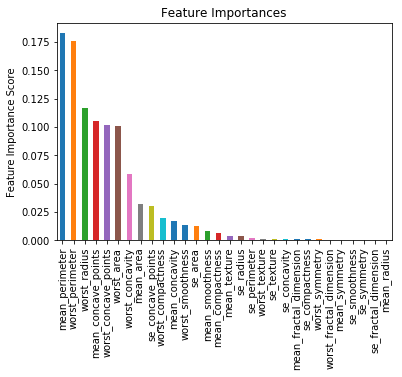

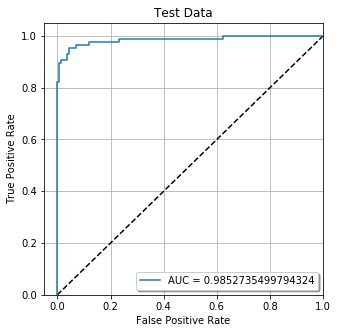

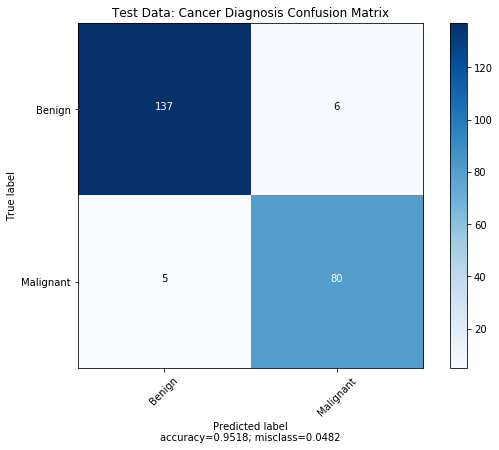

              precision    recall  f1-score   support

           B       0.95      0.97      0.96       143
           M       0.95      0.92      0.93        85

   micro avg       0.95      0.95      0.95       228
   macro avg       0.95      0.94      0.95       228
weighted avg       0.95      0.95      0.95       228



In [37]:
modelfit(gsearch3.best_estimator_, df, predictors)

## Tune max_features

In [40]:
param_test4 = {'max_features': (.4, .5, .6, .7, .75, .8, .9)}

gsearch4 = GridSearchCV(estimator = ensemble.GradientBoostingClassifier(criterion='friedman_mse', init=None,
               learning_rate=0.1, loss='deviance', max_depth=2,
               max_features='sqrt', max_leaf_nodes=None,
               min_impurity_decrease=0.0, min_impurity_split=None,
               min_samples_leaf=6, min_samples_split=74,
               min_weight_fraction_leaf=0.0, n_estimators=36,
               n_iter_no_change=None, presort='auto', random_state=10,
               subsample=0.8, tol=0.0001, validation_fraction=0.1,
               verbose=0, warm_start=False),
param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(X_train, y_train)
gsearch4.best_estimator_, gsearch4.best_params_, gsearch4.best_score_

(GradientBoostingClassifier(criterion='friedman_mse', init=None,
               learning_rate=0.1, loss='deviance', max_depth=2,
               max_features=0.5, max_leaf_nodes=None,
               min_impurity_decrease=0.0, min_impurity_split=None,
               min_samples_leaf=6, min_samples_split=74,
               min_weight_fraction_leaf=0.0, n_estimators=36,
               n_iter_no_change=None, presort='auto', random_state=10,
               subsample=0.8, tol=0.0001, validation_fraction=0.1,
               verbose=0, warm_start=False),
 {'max_features': 0.5},
 0.9893810375670841)


Model Report
Accuracy : 0.9971
AUC Score (Train): 0.999742
CV Score : Mean - 0.989381 | Std - 0.007535614 | Min - 0.9767442 | Max - 1


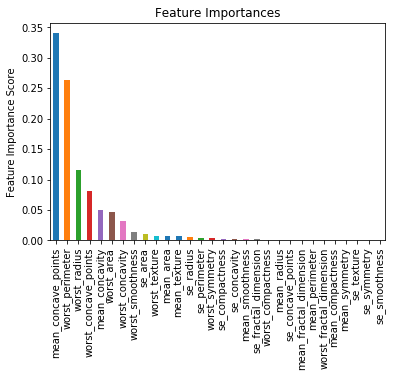

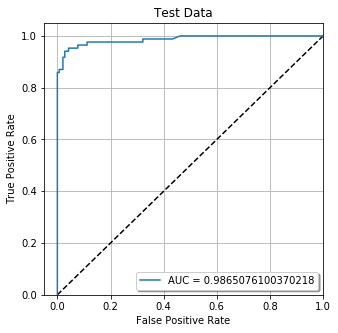

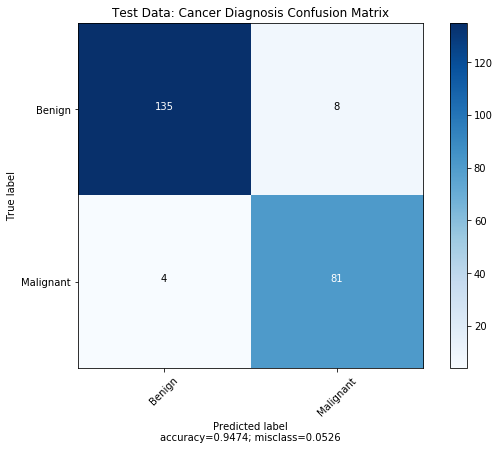

              precision    recall  f1-score   support

           B       0.95      0.97      0.96       143
           M       0.95      0.92      0.93        85

   micro avg       0.95      0.95      0.95       228
   macro avg       0.95      0.94      0.95       228
weighted avg       0.95      0.95      0.95       228



In [41]:
modelfit(gsearch4.best_estimator_, df, predictors)

## Tune Subsampling

In [42]:

param_test5 = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}

gsearch5 = GridSearchCV(estimator = ensemble.GradientBoostingClassifier(criterion='friedman_mse', init=None,
               learning_rate=0.1, loss='deviance', max_depth=2,
               max_features=0.5, max_leaf_nodes=None,
               min_impurity_decrease=0.0, min_impurity_split=None,
               min_samples_leaf=6, min_samples_split=74,
               min_weight_fraction_leaf=0.0, n_estimators=36,
               n_iter_no_change=None, presort='auto', random_state=10,
               tol=0.0001, validation_fraction=0.1,
               verbose=0, warm_start=False),
param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch5.fit(X_train, y_train)
gsearch5.best_estimator_, gsearch5.best_params_, gsearch5.best_score_

(GradientBoostingClassifier(criterion='friedman_mse', init=None,
               learning_rate=0.1, loss='deviance', max_depth=2,
               max_features=0.5, max_leaf_nodes=None,
               min_impurity_decrease=0.0, min_impurity_split=None,
               min_samples_leaf=6, min_samples_split=74,
               min_weight_fraction_leaf=0.0, n_estimators=36,
               n_iter_no_change=None, presort='auto', random_state=10,
               subsample=0.9, tol=0.0001, validation_fraction=0.1,
               verbose=0, warm_start=False),
 {'subsample': 0.9},
 0.9901323792486583)


Model Report
Accuracy : 0.9941
AUC Score (Train): 0.999890
CV Score : Mean - 0.9901324 | Std - 0.0067526 | Min - 0.9795349 | Max - 1


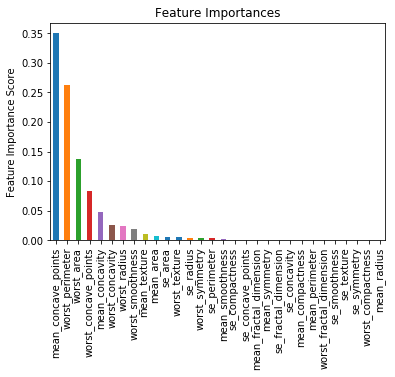

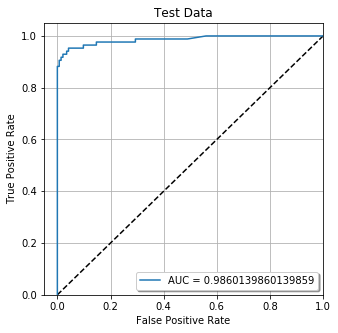

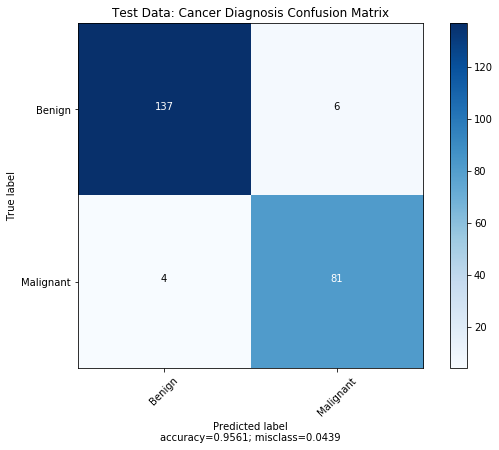

              precision    recall  f1-score   support

           B       0.95      0.97      0.96       143
           M       0.95      0.92      0.93        85

   micro avg       0.95      0.95      0.95       228
   macro avg       0.95      0.94      0.95       228
weighted avg       0.95      0.95      0.95       228



In [43]:
modelfit(gsearch5.best_estimator_, df, predictors)

## Decrease learning rate and increase number of trees proportionally


Model Report
Accuracy : 0.9912
AUC Score (Train): 0.999411
CV Score : Mean - 0.9890233 | Std - 0.007112478 | Min - 0.9776744 | Max - 1


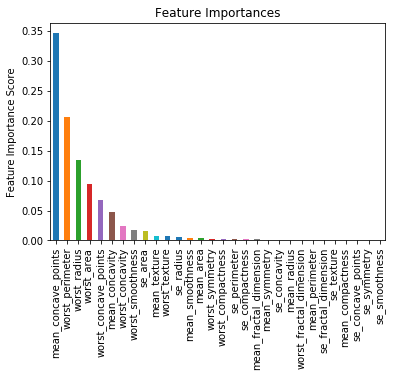

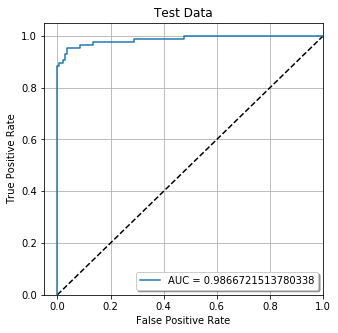

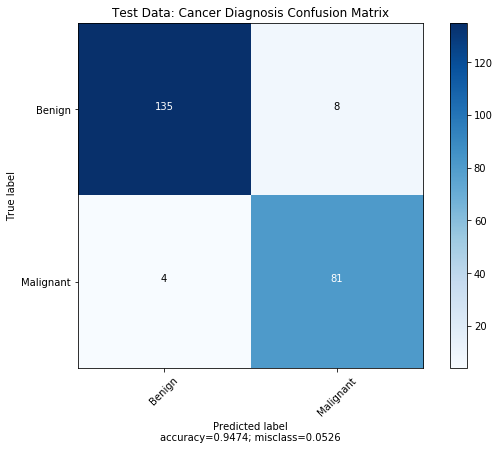

              precision    recall  f1-score   support

           B       0.95      0.97      0.96       143
           M       0.95      0.92      0.93        85

   micro avg       0.95      0.95      0.95       228
   macro avg       0.95      0.94      0.95       228
weighted avg       0.95      0.95      0.95       228



In [44]:
predictors = [x for x in X_train.columns if x not in df[['id', 'dx']]]
gbm_tuned_1 = ensemble.GradientBoostingClassifier(
               criterion='friedman_mse', init=None,
               learning_rate=0.05, loss='deviance', max_depth=2,
               max_features=.5, max_leaf_nodes=None,
               min_impurity_decrease=0.0, min_impurity_split=None,
               min_samples_leaf=6, min_samples_split=74,
               min_weight_fraction_leaf=0.0, n_estimators=58,
               n_iter_no_change=None, presort='auto', random_state=10,
               subsample=0.75, tol=0.0001, validation_fraction=0.1,
               verbose=0, warm_start=False)
modelfit(gbm_tuned_1, df, predictors)

In [70]:
def modelfit2(alg, df_reduced, predictors3, performCV=True, printFeatureImportance=True, cv_folds=5):
    
    #Fit the algorithm on the data
    alg.fit(X_train3, y_train3)
        
    #Predict training set:
    df_predictions = alg.predict(X_train3)
    df_predprob = alg.predict_proba(X_train3)[:,1]
  
    #Perform cross-validation:
    if performCV:
        cv_score = cross_val_score(alg, X_train3, y_train3, cv=cv_folds, scoring='roc_auc')
    
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(y_train3.values, df_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(y_train3, df_predprob))
    
    if performCV:
        print("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, predictors3).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')
    
    # get roc/auc info
    # https://stackoverflow.com/questions/35953300/valueerror-data-is-not-binary-and-pos-label-is-not-specified-for-roc-curve/35953684
    Y_score = alg.predict_proba(X_test3)[:,1]
    fpr = dict()
    tpr = dict()
    fpr, tpr, _ = roc_curve(y_test3, Y_score, pos_label='M')

    roc_auc = dict()
    roc_auc = auc(fpr, tpr)

    # make the plot
    
    plt.figure(figsize=(5,5))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.title("Test Data")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)
    plt.plot(fpr, tpr, label='AUC = {0}'.format(roc_auc))        
    plt.legend(loc="lower right", shadow=True, fancybox =True) 
    plt.show()

    # Confusion Matrix to identify Type I and Type II Errors:
    y_pred_confusion_matrix = alg.predict(X_test3)

    cm = confusion_matrix(y_test3, y_pred_confusion_matrix)
    target_names = 'Benign', 'Malignant'

    plot_confusion_matrix(cm, target_names, title='Test Data: Cancer Diagnosis Confusion Matrix')

In [71]:
# https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8
# take out string related columns to avoid errors and remove all other added columns as well

df_reduced = df[
    ['dx','mean_concave_points', 'worst_perimeter', 'worst_radius', 'worst_area', 'worst_concave_points', 
     'mean_concavity', 'worst_concavity', 'worst_smoothness', 'se_area']
            ]

columns_x = ['mean_concave_points', 'worst_perimeter', 'worst_radius', 'worst_area', 'worst_concave_points', 
             'mean_concavity', 'worst_concavity', 'worst_smoothness', 'se_area']
 
X3 = df_reduced[columns_x]

y3 = df_reduced['dx']

X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size=.4, random_state=0, stratify=y3)



Model Report
Accuracy : 1
AUC Score (Train): 1.000000
CV Score : Mean - 0.9855671 | Std - 0.008311497 | Min - 0.9767442 | Max - 1


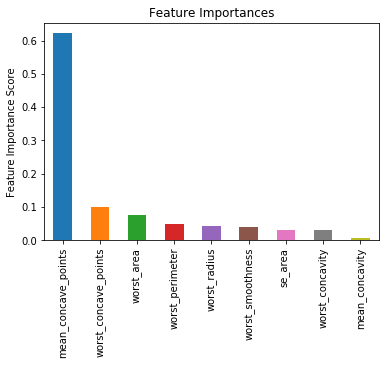

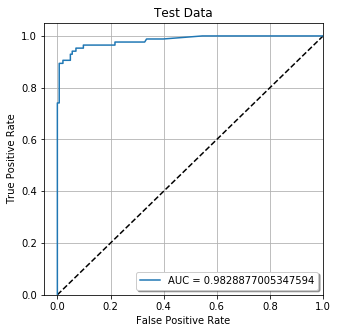

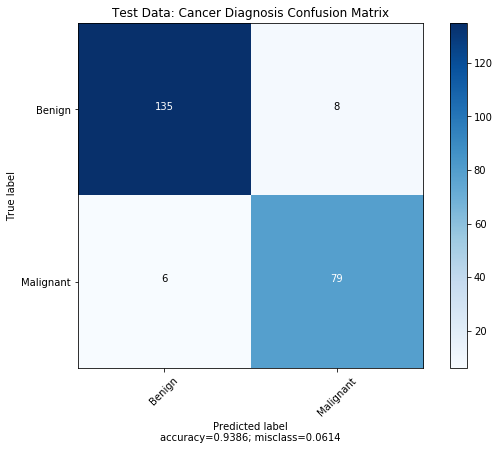

              precision    recall  f1-score   support

           B       0.95      0.97      0.96       143
           M       0.95      0.92      0.93        85

   micro avg       0.95      0.95      0.95       228
   macro avg       0.95      0.94      0.95       228
weighted avg       0.95      0.95      0.95       228



In [72]:
#Choose all predictors except target & IDcols
predictors33 = [x for x in X_train3.columns if x not in df_reduced['dx']]

gbm00 = ensemble.GradientBoostingClassifier(random_state=10)
modelfit2(gbm00, df_reduced, predictors3)

### New Baseline (fewer features)

In [74]:
#Choose all predictors except target & IDcols
predictors3 = [x for x in X_train3.columns if x not in df_reduced[['dx']]]

param_test6 = {'n_estimators':range(1,71,1)}

gsearch6 = GridSearchCV(estimator = ensemble.GradientBoostingClassifier(learning_rate=0.1, 
                                                               min_samples_split=500,min_samples_leaf=50,
                                                               max_depth=8,max_features='sqrt',subsample=0.8,
                                                               random_state=10), 
param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch6.fit(X_train3, y_train3)
gsearch6.best_estimator_, gsearch6.best_params_, gsearch6.best_score_

(GradientBoostingClassifier(criterion='friedman_mse', init=None,
               learning_rate=0.1, loss='deviance', max_depth=8,
               max_features='sqrt', max_leaf_nodes=None,
               min_impurity_decrease=0.0, min_impurity_split=None,
               min_samples_leaf=50, min_samples_split=500,
               min_weight_fraction_leaf=0.0, n_estimators=1,
               n_iter_no_change=None, presort='auto', random_state=10,
               subsample=0.8, tol=0.0001, validation_fraction=0.1,
               verbose=0, warm_start=False), {'n_estimators': 1}, 0.5)

In [75]:
# max depth and num_samples_split
param_test7 = {'n_estimators':range(1,41,1),'max_depth':range(1,4,1), 'min_samples_split':range(2,203,10)}
gsearch7 = GridSearchCV(estimator = ensemble.GradientBoostingClassifier(learning_rate=0.1,
                                                                        max_features='sqrt', subsample=0.8,
                                                                        random_state=10), 
param_grid = param_test7, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch7.fit(X_train3, y_train3)
gsearch7.best_estimator_, gsearch7.best_params_, gsearch7.best_score_

(GradientBoostingClassifier(criterion='friedman_mse', init=None,
               learning_rate=0.1, loss='deviance', max_depth=3,
               max_features='sqrt', max_leaf_nodes=None,
               min_impurity_decrease=0.0, min_impurity_split=None,
               min_samples_leaf=1, min_samples_split=72,
               min_weight_fraction_leaf=0.0, n_estimators=40,
               n_iter_no_change=None, presort='auto', random_state=10,
               subsample=0.8, tol=0.0001, validation_fraction=0.1,
               verbose=0, warm_start=False),
 {'max_depth': 3, 'min_samples_split': 72, 'n_estimators': 40},
 0.9895813953488372)

In [77]:
#min samples split and min samples leaf
param_test8 = {'min_samples_split':range(62,83,1), 'min_samples_leaf':range(1,11,1)}
gsearch8 = GridSearchCV(estimator = ensemble.GradientBoostingClassifier(learning_rate=0.1, n_estimators=40,max_depth=3,
                                                               max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test8, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch8.fit(X_train3, y_train3)
gsearch8.best_estimator_, gsearch8.best_params_, gsearch8.best_score_

(GradientBoostingClassifier(criterion='friedman_mse', init=None,
               learning_rate=0.1, loss='deviance', max_depth=3,
               max_features='sqrt', max_leaf_nodes=None,
               min_impurity_decrease=0.0, min_impurity_split=None,
               min_samples_leaf=5, min_samples_split=63,
               min_weight_fraction_leaf=0.0, n_estimators=40,
               n_iter_no_change=None, presort='auto', random_state=10,
               subsample=0.8, tol=0.0001, validation_fraction=0.1,
               verbose=0, warm_start=False),
 {'min_samples_leaf': 5, 'min_samples_split': 63},
 0.9915706618962433)

In [79]:
#max features
param_test9 = {'max_features': (.3, .4, .5, .6, .7, .75, .8, .9)}

gsearch9 = GridSearchCV(estimator = ensemble.GradientBoostingClassifier(criterion='friedman_mse', init=None,
               learning_rate=0.1, loss='deviance', max_depth=3,
               max_features='sqrt', max_leaf_nodes=None,
               min_impurity_decrease=0.0, min_impurity_split=None,
               min_samples_leaf=5, min_samples_split=63,
               min_weight_fraction_leaf=0.0, n_estimators=40,
               n_iter_no_change=None, presort='auto', random_state=10,
               subsample=0.8, tol=0.0001, validation_fraction=0.1,
               verbose=0, warm_start=False),
param_grid = param_test9, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch9.fit(X_train3, y_train3)
gsearch9.best_estimator_, gsearch9.best_params_, gsearch9.best_score_

(GradientBoostingClassifier(criterion='friedman_mse', init=None,
               learning_rate=0.1, loss='deviance', max_depth=3,
               max_features=0.4, max_leaf_nodes=None,
               min_impurity_decrease=0.0, min_impurity_split=None,
               min_samples_leaf=5, min_samples_split=63,
               min_weight_fraction_leaf=0.0, n_estimators=40,
               n_iter_no_change=None, presort='auto', random_state=10,
               subsample=0.8, tol=0.0001, validation_fraction=0.1,
               verbose=0, warm_start=False),
 {'max_features': 0.4},
 0.9915706618962433)

In [88]:
#subsample
param_test10 = {'max_features': (.2, .3, .4, .5, .6), 'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}

gsearch10 = GridSearchCV(estimator = ensemble.GradientBoostingClassifier(criterion='friedman_mse', init=None,
               learning_rate=0.1, loss='deviance', max_depth=3,
               max_features='sqrt', max_leaf_nodes=None,
               min_impurity_decrease=0.0, min_impurity_split=None,
               min_samples_leaf=5, min_samples_split=63,
               min_weight_fraction_leaf=0.0, n_estimators=40,
               n_iter_no_change=None, presort='auto', random_state=10,
               tol=0.0001, validation_fraction=0.1,
               verbose=0, warm_start=False),
param_grid = param_test10, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch10.fit(X_train3, y_train3)
gsearch10.best_estimator_, gsearch10.best_params_, gsearch10.best_score_

(GradientBoostingClassifier(criterion='friedman_mse', init=None,
               learning_rate=0.1, loss='deviance', max_depth=3,
               max_features=0.3, max_leaf_nodes=None,
               min_impurity_decrease=0.0, min_impurity_split=None,
               min_samples_leaf=5, min_samples_split=63,
               min_weight_fraction_leaf=0.0, n_estimators=40,
               n_iter_no_change=None, presort='auto', random_state=10,
               subsample=0.7, tol=0.0001, validation_fraction=0.1,
               verbose=0, warm_start=False),
 {'max_features': 0.3, 'subsample': 0.7},
 0.9919642218246869)


Model Report
Accuracy : 0.9912
AUC Score (Train): 0.998712
CV Score : Mean - 0.9919642 | Std - 0.005260711 | Min - 0.984186 | Max - 1


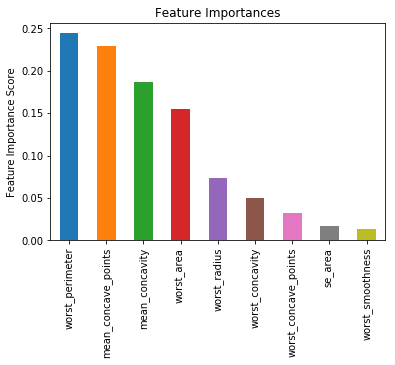

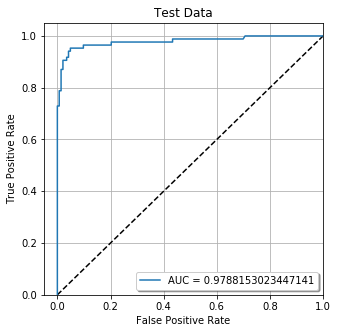

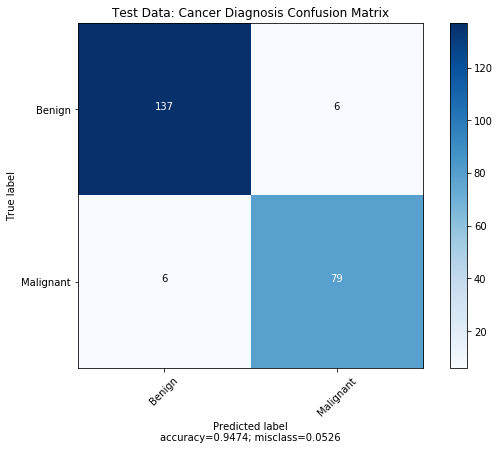

              precision    recall  f1-score   support

           B       0.95      0.97      0.96       143
           M       0.95      0.92      0.93        85

   micro avg       0.95      0.95      0.95       228
   macro avg       0.95      0.94      0.95       228
weighted avg       0.95      0.95      0.95       228



In [89]:
modelfit2(gsearch10.best_estimator_, df_reduced, predictors3)


Model Report
Accuracy : 0.9765
AUC Score (Train): 0.997424
CV Score : Mean - 0.9899392 | Std - 0.007304056 | Min - 0.9776744 | Max - 1


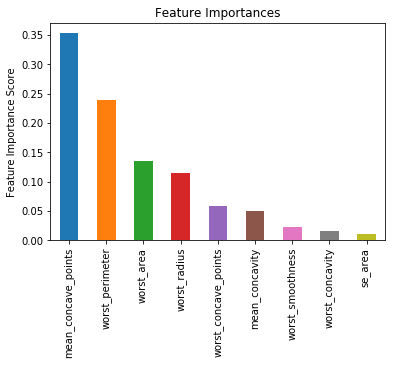

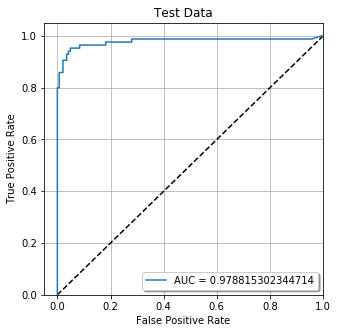

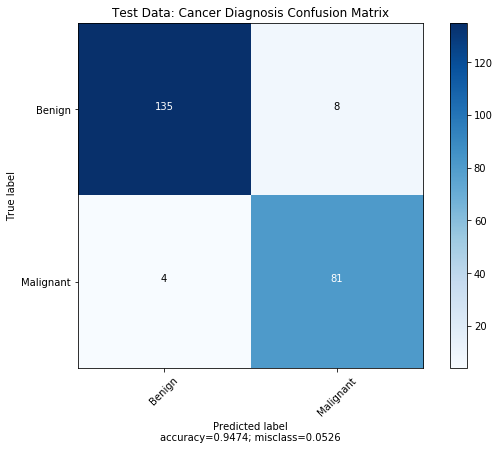

              precision    recall  f1-score   support

           B       0.95      0.97      0.96       143
           M       0.95      0.92      0.93        85

   micro avg       0.95      0.95      0.95       228
   macro avg       0.95      0.94      0.95       228
weighted avg       0.95      0.95      0.95       228



In [95]:
predictors3 = [x for x in X_train3.columns if x not in df[['dx']]]

gbm_tuned_2 = ensemble.GradientBoostingClassifier(
               criterion='friedman_mse', init=None,
               learning_rate=0.05, loss='deviance', max_depth=3,
               max_features='sqrt', max_leaf_nodes=None,
               min_impurity_decrease=0.0, min_impurity_split=None,
               min_samples_leaf=5, min_samples_split=63,
               min_weight_fraction_leaf=0.0, n_estimators=40,
               n_iter_no_change=None, presort='auto', random_state=10,
               subsample=0.7, tol=0.0001, validation_fraction=0.1,
               verbose=0, warm_start=False)
modelfit2(gbm_tuned_2, df_reduced, predictors3)

## Conclusion:
- Checking for class imbalance can make a big difference in accuracy
- When there is a class imbalance, accuracy is not a good metric - looking at Type I and Type II errors and F1 Scores can be most useful.
- There seems to be a trade off between Type I and Type II errors and knowing the domain is useful in identifying criteria for stopping point with data: in this case, there is a higher tolerance for false positives than for false negatives.
- Classification of someone with a malignant tumor as having a benign tumor is less acceptable than classifying someone with a benign tumor as having a malignant tumor, since "missing" the malignant dx has catastrophic consequences.
- One pre-processing approach is to stratify the data in the test, train, split so that the test data has the same ratio of M to B cases.
- Other possibilities are down sampling or up sampling.
- In this case, a logistic regression was less successful at reducing false negatives than GBM.  Stratifying the data resulted in overall improvement in false negative errors.
- The following features were most relevant in Malignant tumor dx:

'mean_concave_points'
'worst_perimeter',
'worst_radius'
'worst_area'
'worst_concave_points'
'mean_concavity'
'worst_concavity'
'worst_smoothness'
'se_area'